In [46]:
import pandas as pd
import numpy as np
from pandas import json_normalize 
import datetime as dt
from datetime import datetime
import time
import requests
import json



import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option('display.max_colwidth', None)



In [47]:
# Marinade Finance has a direct stake product and liquids taking product
# Can return total staked via their Grafana Dashboard: https://stats.marinade.finance/d/sqUQd1Onk/marinade-kpi-dashboard?orgId=1&viewPanel=57
# Extract is from October 9th, 2023
marinade = pd.read_csv("marinade-total-tvl.csv")

# Remove duplicate dates
marinade = marinade[marinade['Time'].str.endswith('00:00:00')]

# Turn into dt
marinade['Time'] = pd.to_datetime(marinade['Time'])

# Rename columns
marinade = marinade.rename(columns={'Time': 'date'})
marinade = marinade.rename(columns={'SOL Staked': 'marinade_total_staked'})

# Set to correct data type
marinade['date'] = marinade['date'].astype(str)

In [48]:
protocols = ['lido', 'jito', 'blazestake','jpool','socean']
length = len(protocols)

In [49]:
for i in range(length):
    response = requests.get("https://api.llama.fi/protocol/"+protocols[i])
    data = response.json()
    if protocols[i] == 'lido': 
        lido = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        lido = lido.rename({'tokens.SOL': 'lido_sol'}, axis=1)
        lido['date'] = pd.to_datetime(lido['date'], unit='s').dt.strftime('%Y-%m-%d')
    if protocols[i] == 'jito': 
        jito = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        jito = jito.rename({'tokens.SOL': 'jito_sol'}, axis=1)
        jito['date'] = pd.to_datetime(jito['date'], unit='s').dt.strftime('%Y-%m-%d')  
    if protocols[i] == 'blazestake': 
        blaze = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        blaze = blaze.rename({'tokens.BSOL': 'blaze_sol'}, axis=1)
        blaze['date'] = pd.to_datetime(blaze['date'], unit='s').dt.strftime('%Y-%m-%d')
    if protocols[i] == 'jpool': 
        jpool = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        jpool = jpool.rename({'tokens.JSOL': 'jpool_sol'}, axis=1)
        jpool['date'] = pd.to_datetime(jpool['date'], unit='s').dt.strftime('%Y-%m-%d')
    if protocols[i] == 'socean': 
        socean = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        socean = socean.rename({'tokens.SOL': 'socean_sol'}, axis=1)
        socean['date'] = pd.to_datetime(socean['date'], unit='s').dt.strftime('%Y-%m-%d')
    
 

In [50]:
#join
df = marinade.merge(lido, left_on='date', right_on='date', how='left')
df = df.merge(jito, left_on='date', right_on='date', how='left')
df = df.merge(blaze, left_on='date', right_on='date', how='left')
df = df.merge(jpool, left_on='date', right_on='date', how='left')
df = df.merge(socean, left_on='date', right_on='date', how='left')


In [51]:
#sum
cols = list(df)
cols.remove("date")
df["sum"] = df[cols].sum(axis=1)

#sum lido, jpool, socean
df['competitors_sum'] = df['lido_sol'] + df['jito_sol'] + df['blaze_sol']+ df['jpool_sol'] + df['socean_sol']

In [52]:
#distribution
df['marinade_distribution'] = df['marinade_total_staked'] / df['sum']
df['lido_distribution'] = df['lido_sol'] / df['sum']
df['jito_distribution'] = df['jito_sol'] / df['sum']
df['blaze_distribution'] = df['blaze_sol'] / df['sum']
df['jpool_distribution'] = df['jpool_sol'] / df['sum']
df['socean_distribution'] = df['socean_sol'] / df['sum']

df['lido_comp_distribution'] = df['lido_sol'] / df['competitors_sum']
df['jito_comp_distribution'] = df['jito_sol'] / df['competitors_sum']
df['blaze_comp_distribution'] = df['blaze_sol'] / df['competitors_sum']
df['jpool_comp_distribution'] = df['jpool_sol'] / df['competitors_sum']
df['socean_comp_distribution'] = df['socean_sol'] / df['competitors_sum']

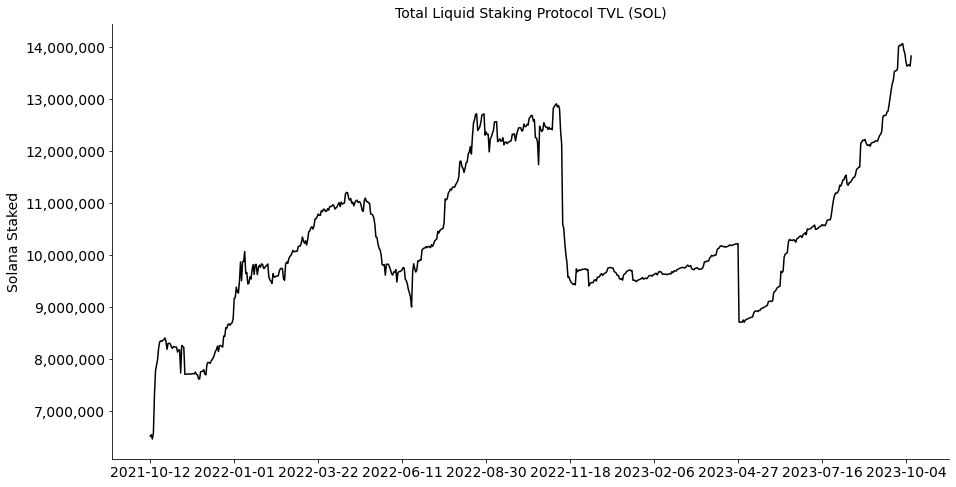

In [53]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
total = df['sum']

plt.plot(x,total, label='Total SOL Staked', color ='Black')


#remove lines
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)   

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)    
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.title('Total Liquid Staking Protocol TVL (SOL)', fontsize=14) # adding a title
ax.yaxis.set_major_formatter('{x:1,.0f}')
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Solana Staked',fontsize=14) # y label
plt.show()

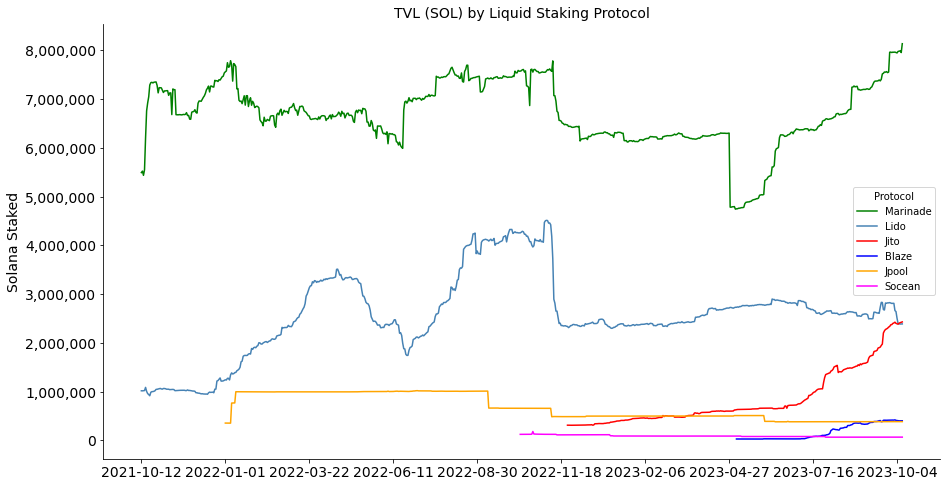

In [54]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
marinade = df['marinade_total_staked']
lido = df['lido_sol']
jito = df['jito_sol']
blaze = df['blaze_sol']
jpool = df['jpool_sol']
socean = df['socean_sol']

plt.plot(x,marinade, label='Marinade', color ='Green')
plt.plot(x,lido, label='Lido', color ='steelblue')
plt.plot(x,jito, label='Jito', color ='red')
plt.plot(x,blaze, label='Blaze', color ='blue')
plt.plot(x,jpool, label='Jpool', color ='orange')
plt.plot(x,socean, label='Socean', color ='magenta')

#add legend
plt.legend(title='Protocol')

#remove lines
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)   

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)    
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('TVL (SOL) by Liquid Staking Protocol', fontsize=14) # adding a title
ax.yaxis.set_major_formatter('{x:1,.0f}')
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Solana Staked',fontsize=14) # y label
plt.show()

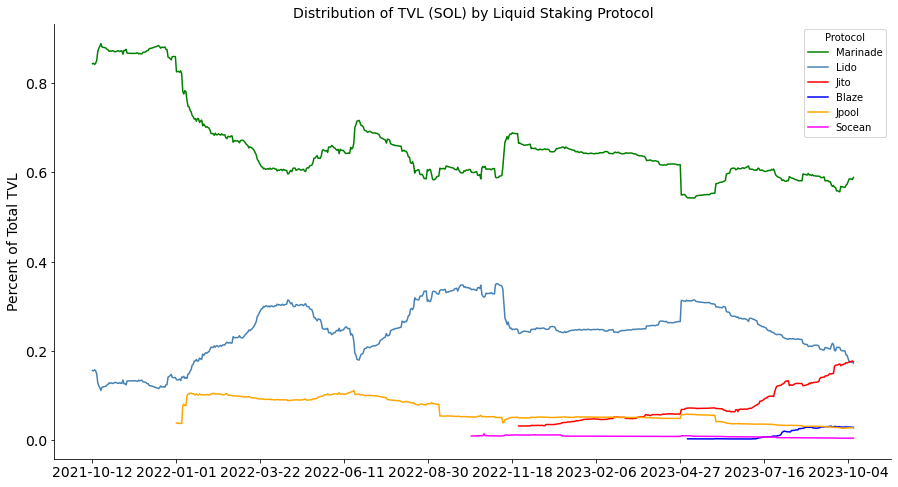

In [55]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
marinade = df['marinade_distribution']
lido = df['lido_distribution']
jito = df['jito_distribution']
blaze = df['blaze_distribution']
jpool = df['jpool_distribution']
socean = df['socean_distribution']

plt.plot(x,marinade, label='Marinade', color ='Green')
plt.plot(x,lido, label='Lido', color ='steelblue')
plt.plot(x,jito, label='Jito', color ='red')
plt.plot(x,blaze, label='Blaze', color ='blue')
plt.plot(x,jpool, label='Jpool', color ='orange')
plt.plot(x,socean, label='Socean', color ='magenta')

#add legend
plt.legend(title='Protocol')

#remove lines
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)   

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('Distribution of TVL (SOL) by Liquid Staking Protocol', fontsize=14) # adding a title
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Percent of Total TVL',fontsize=14) # y label
plt.show()

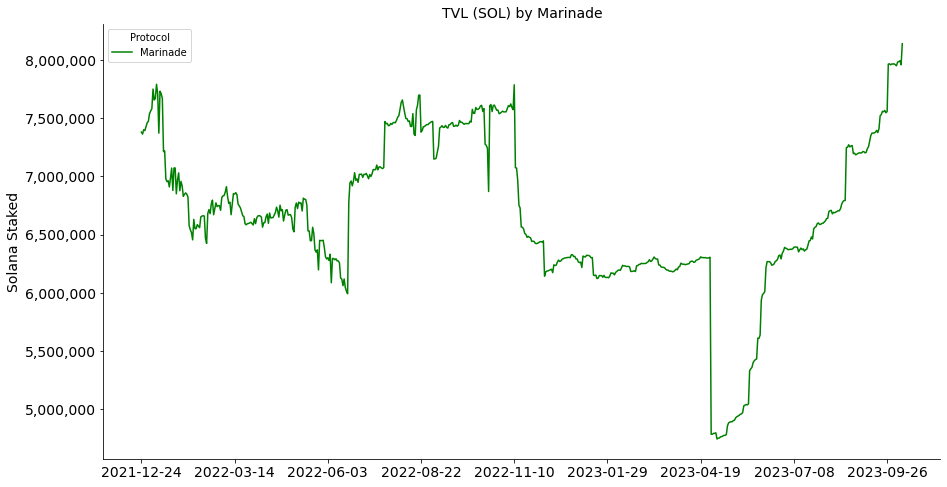

In [57]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

df_f = df[df['date'] >= '2021-12-24']

x = df_f['date']
marinade = df_f['marinade_total_staked']

plt.plot(x,marinade, label='Marinade', color ='Green')

#add legend
plt.legend(title='Protocol')

#remove lines
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)   

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)    
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('TVL (SOL) by Marinade', fontsize=14) # adding a title
ax.yaxis.set_major_formatter('{x:1,.0f}')
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Solana Staked',fontsize=14) # y label
plt.show()

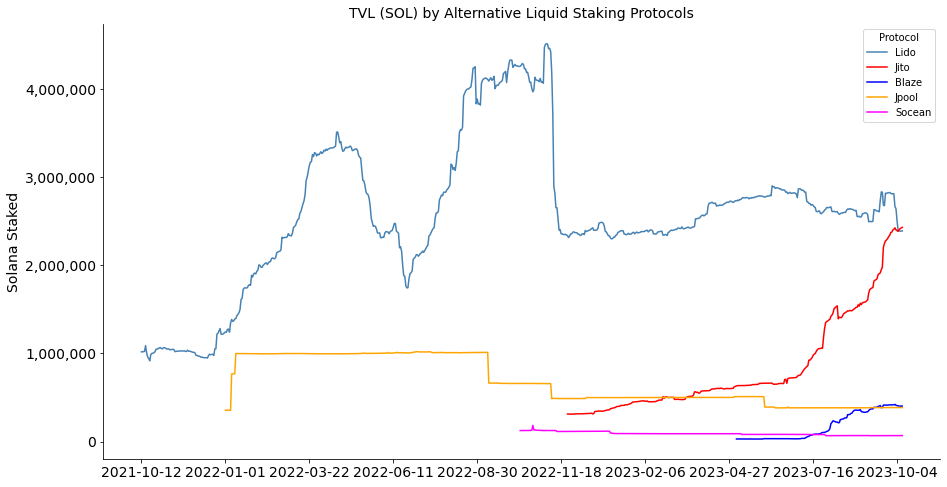

In [58]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
lido = df['lido_sol']
jito = df['jito_sol']
blaze = df['blaze_sol']
jpool = df['jpool_sol']
socean = df['socean_sol']

plt.plot(x,lido, label='Lido', color ='steelblue')
plt.plot(x,jito, label='Jito', color ='red')
plt.plot(x,blaze, label='Blaze', color ='blue')
plt.plot(x,jpool, label='Jpool', color ='orange')
plt.plot(x,socean, label='Socean', color ='magenta')

#add legend
plt.legend(title='Protocol')

#remove lines
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)   

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)    
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('TVL (SOL) by Alternative Liquid Staking Protocols', fontsize=14) # adding a title
ax.yaxis.set_major_formatter('{x:1,.0f}')
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Solana Staked',fontsize=14) # y label
plt.show()

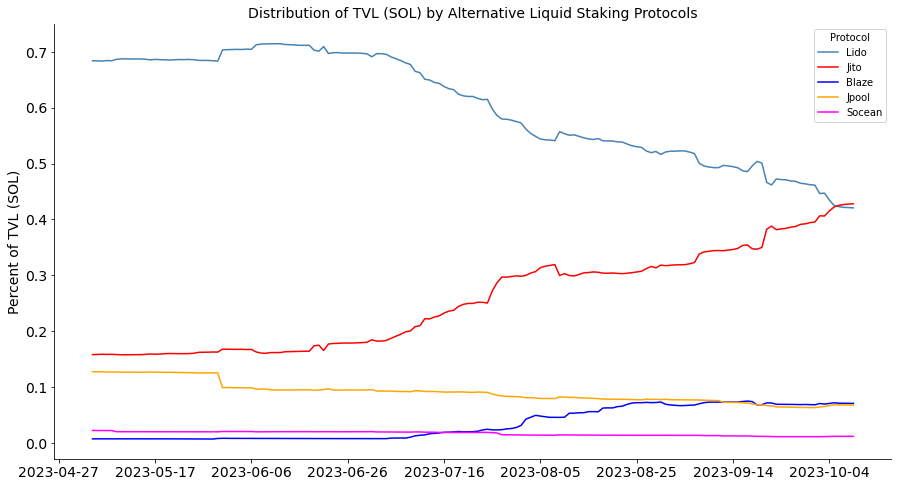

In [59]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
lido = df['lido_comp_distribution']
jito = df['jito_comp_distribution']
blaze = df['blaze_comp_distribution']
jpool = df['jpool_comp_distribution']
socean = df['socean_comp_distribution']

plt.plot(x,lido, label='Lido', color ='steelblue')
plt.plot(x,jito, label='Jito', color ='red')
plt.plot(x,blaze, label='Blaze', color ='blue')
plt.plot(x,jpool, label='Jpool', color ='orange')
plt.plot(x,socean, label='Socean', color ='magenta')

#add legend
plt.legend(title='Protocol')

#remove lines
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)   

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('Distribution of TVL (SOL) by Alternative Liquid Staking Protocols', fontsize=14) # adding a title
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Percent of TVL (SOL)',fontsize=14) # y label
plt.show()

In [ ]:
df.to_csv('liquid_staking.csv')